In [31]:
%matplotlib inline

import ast
import os
import IPython.display as ipd

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm

import librosa
import librosa.display

plt.rcParams['figure.figsize'] = (17, 5)

In [32]:
def load_df(filepath: str) -> pd.DataFrame:
    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [33]:
FMA_DS_PATH = os.getcwd() + '/data/FMA/fma_metadata/'

tracks = load_df(FMA_DS_PATH + 'tracks.csv')
genres = load_df(FMA_DS_PATH + 'genres.csv')
features = load_df(FMA_DS_PATH + 'features.csv')
echonest = load_df(FMA_DS_PATH + 'echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [34]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
10,NaT,NaT,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"[philly, kurt vile]",http://kurtvile.com,NaN
20,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN


,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large


In [35]:
medium = tracks[tracks['set', 'subset'] <= 'small']
medium.shape

(8000, 52)

In [36]:
medium = tracks[tracks['set', 'subset'] <= 'medium']
medium.shape

(25000, 52)

In [37]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4


In [38]:
genres.sort_values('#tracks').head(10)

,#tracks,parent,title,top_level
genre_id,,,,
175,0,86,Bollywood,2
178,0,4,Be-Bop,4
377,1,19,Deep Funk,14
173,4,86,N. Indian Traditional,2
493,4,651,Western Swing,9
374,9,20,Banter,20
808,12,46,Salsa,2
174,17,86,South Indian Traditional,2
465,18,20,Musical Theater,20


In [39]:
print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
for column in columns:
    ipd.display(features[column].head().style.format('{:.2f}'))

518 features for 106574 tracks


In [40]:
print('{1} features for {0} tracks'.format(*echonest.shape))
ipd.display(echonest['echonest', 'metadata'].head())
ipd.display(echonest['echonest', 'audio_features'].head())
ipd.display(echonest['echonest', 'social_features'].head())
ipd.display(echonest['echonest', 'ranks'].head())

249 features for 13129 tracks


,album_date,album_name,artist_latitude,artist_location,artist_longitude,artist_name,release
track_id,,,,,,,
2,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
3,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
5,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
10,2008-03-11,Constant Hitmaker,39.9523,"Philadelphia, PA, US",-75.1624,Kurt Vile,Constant Hitmaker
134,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss
track_id,,,,,
2,0.388990,0.386740,0.406370,0.000000,0.000000
3,0.388990,0.386740,0.406370,0.000000,0.000000
5,0.388990,0.386740,0.406370,0.000000,0.000000
10,0.557339,0.614272,0.798387,0.005158,0.354516
134,0.388990,0.386740,0.406370,0.000000,0.000000


,artist_discovery_rank,artist_familiarity_rank,artist_hotttnesss_rank,song_currency_rank,song_hotttnesss_rank
track_id,,,,,
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
10,2635.0,2544.0,397.0,115691.0,67609.0
134,NaN,NaN,NaN,NaN,NaN


,000,001,002,003,004,005,006,007,008,009,...,214,215,216,217,218,219,220,221,222,223
track_id,,,,,,,,,,,,,,,,,,,,,
2,0.877233,0.588911,0.354243,0.295090,0.298413,0.309430,0.304496,0.334579,0.249495,0.259656,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
3,0.534429,0.537414,0.443299,0.390879,0.344573,0.366448,0.419455,0.747766,0.460901,0.392379,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
5,0.548093,0.720192,0.389257,0.344934,0.361300,0.402543,0.434044,0.388137,0.512487,0.525755,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
10,0.311404,0.711402,0.321914,0.500601,0.250963,0.321316,0.734250,0.325188,0.373012,0.235840,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
134,0.610849,0.569169,0.428494,0.345796,0.376920,0.460590,0.401371,0.449900,0.428946,0.446736,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


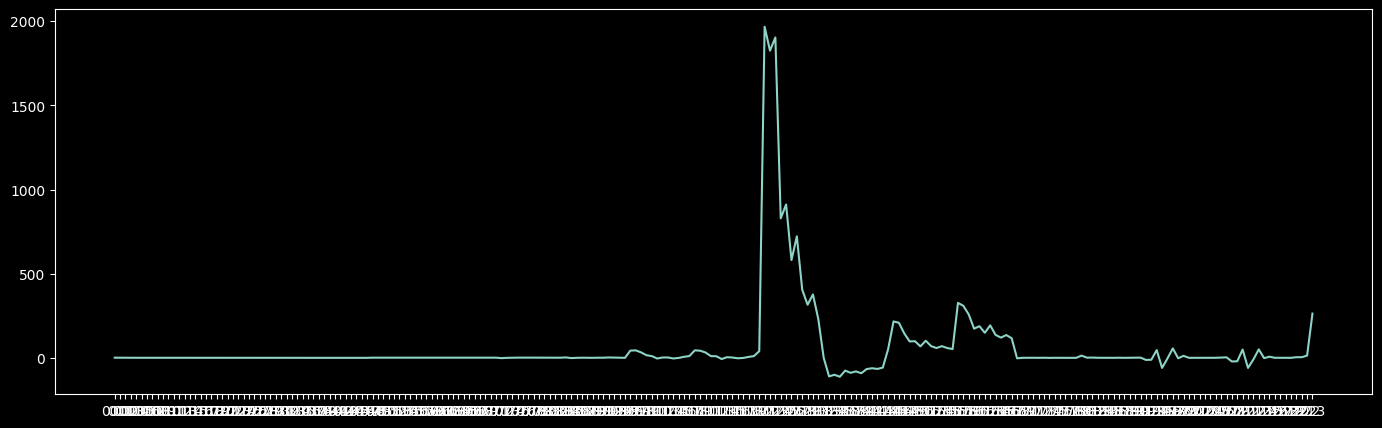

In [41]:
ipd.display(echonest['echonest', 'temporal_features'].head())
x = echonest.loc[2, ('echonest', 'temporal_features')]
plt.plot(x)

((3551, 2), (3551,))

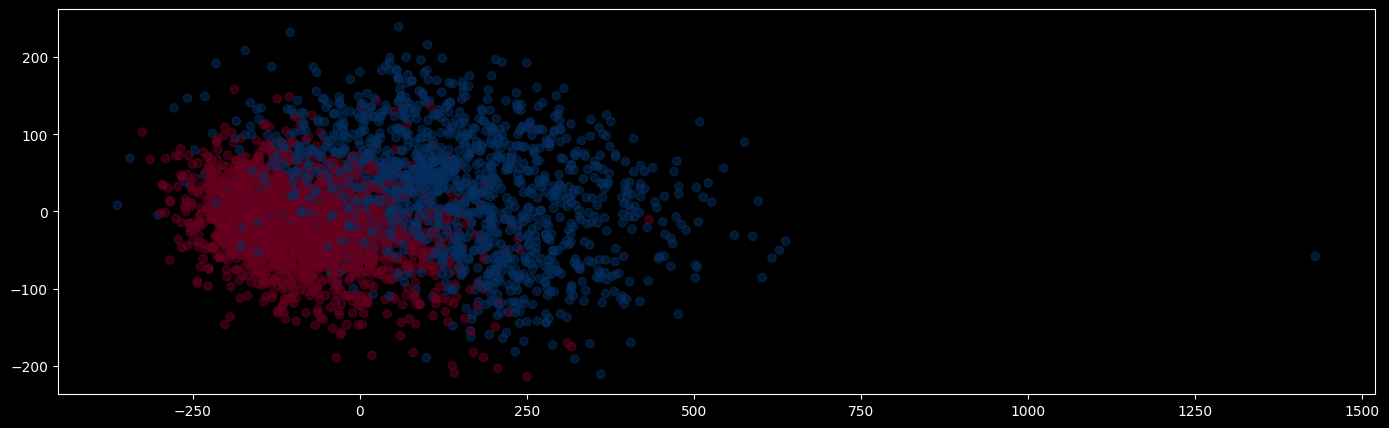

In [42]:
medium = tracks['set', 'subset'] <= 'medium'
genre1 = tracks['track', 'genre_top'] == 'Instrumental'
genre2 = tracks['track', 'genre_top'] == 'Hip-Hop'

X = features.loc[medium & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[medium & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

In [43]:
medium = tracks['set', 'subset'] <= 'medium'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[medium & train, ('track', 'genre_top')]
y_val = tracks.loc[medium & val, ('track', 'genre_top')]
y_test = tracks.loc[medium & test, ('track', 'genre_top')]
X_train = features.loc[medium & train, 'mfcc']
X_val = features.loc[medium & val, 'mfcc']
X_test = features.loc[medium & test, 'mfcc']

print(f'Examples: {y_train.size} training, {y_val.size} validation, {y_test.size} testing')
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

Examples: 19922 training, 2505 validation, 2573 testing
140 features, 16 classes


In [44]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 60.98%


In [63]:
from keras.initializers import GlorotNormal
from keras.layers import Dense, Dropout
from keras.models import Model, Sequential

initializer = GlorotNormal()

model: Model = Sequential([
    Dense(512, activation='relu', kernel_initializer=initializer),
    Dense(256, activation='relu', kernel_initializer=initializer),
    Dense(128, activation='relu', kernel_initializer=initializer),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_initializer=initializer),
    Dense(32, activation='relu', kernel_initializer=initializer),
    Dense(8, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [64]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=7, restore_best_weights=True)

model.fit(
    X_train, y_train,
    epochs=50,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val)
)

Epoch 1/50


/mnt/WD-shared/PJATK/PracaMagisterska/kafka-ml/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


ValueError: in user code:

    File "/mnt/WD-shared/PJATK/PracaMagisterska/kafka-ml/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/mnt/WD-shared/PJATK/PracaMagisterska/kafka-ml/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/mnt/WD-shared/PJATK/PracaMagisterska/kafka-ml/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/mnt/WD-shared/PJATK/PracaMagisterska/kafka-ml/lib/python3.10/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/mnt/WD-shared/PJATK/PracaMagisterska/kafka-ml/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/mnt/WD-shared/PJATK/PracaMagisterska/kafka-ml/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/mnt/WD-shared/PJATK/PracaMagisterska/kafka-ml/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/mnt/WD-shared/PJATK/PracaMagisterska/kafka-ml/lib/python3.10/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/mnt/WD-shared/PJATK/PracaMagisterska/kafka-ml/lib/python3.10/site-packages/keras/losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/mnt/WD-shared/PJATK/PracaMagisterska/kafka-ml/lib/python3.10/site-packages/keras/backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 8) are incompatible


In [55]:
statistics = set()
for name, _ in X_test.columns:
    statistics.add(name)
statistics

{'kurtosis', 'max', 'mean', 'median', 'min', 'skew', 'std'}

In [56]:
idx = pd.IndexSlice
mean = X_test.loc[:, X_test.columns.get_level_values(0) == 'mean']
std = X_test.loc[:, X_test.columns.get_level_values(0) == 'std']

In [57]:
mean

statistics      mean                                                    \
number            01        02        03        04        05        06   
track_id                                                                 
181         0.588810  0.500497 -1.671640  0.575433 -0.223185 -1.799739   
182         0.866671  2.178021 -2.063310 -0.019216  0.309943 -3.225569   
564        -0.108586  0.586940  0.796405 -0.461835  0.757081  0.017172   
704         1.165652 -2.131319  0.185356  0.278535  0.008616  1.160020   
705         1.101088 -1.607470  0.091112  0.544443 -0.575574  0.639248   
...              ...       ...       ...       ...       ...       ...   
154305     -2.592281 -0.758224  2.350474 -0.316477  0.018372 -0.855142   
154306     -1.216533 -0.187699 -0.211318 -0.993611 -0.103159 -0.784201   
154307     -1.060342 -2.123124  0.910205  0.403328  0.084926 -1.104667   
154308     -1.016089  0.226182  0.407766 -1.022573 -0.134373 -0.852060   
154309     -1.856538 -1.305580  0.863259 -1.903428 -1.093677 -1.123040   

statistics                                                              \
number            07        08        09        10        11        12   
track_id                                                                 
181         1.238474  0.412999 -0.418229  0.941095 -1.457262  0.265450   
182         2.949073 -0.397661  0.373398  1.576699  1.596991  0.730230   
564         0.560549  0.343186  0.110934  0.309270 -0.045427  0.085642   
704         0.325566  0.350361 -0.225142  0.799580  0.250293  0.471274   
705         0.576904  1.187136  0.474583  1.860693 -0.196075  1.065131   
...              ...       ...       ...       ...       ...       ...   
154305      0.853108 -0.397233  0.146006 -0.403055  0.349010 -0.048437   
154306      0.086370 -0.103180  2.279910  1.163978  0.417202  0.656186   
154307      0.190051  0.137234  1.184508 -0.557680 -0.333618  0.549214   
154308      0.735174 -0.042034  1.611040  0.260356  1.184738 -0.135543   
154309     -0.764116 -1.803550 -1.549511 -1.512399 -1.932995 -1.200717   

statistics                                                              \
number            13        14        15        16        17        18   
track_id                                                                 
181        -0.750996 -1.039551  0.227223 -0.440135 -1.128195  0.353528   
182         2.539329  1.976047  1.265824  1.339898  1.719819 -0.252890   
564        -0.359257  0.377079 -0.602004 -0.243145 -0.254715  0.088121   
704         0.541100  1.541936 -0.016427  0.566969  1.302239  1.063041   
705        -0.189825  1.903492 -0.361853  0.392025 -0.188997  1.080871   
...              ...       ...       ...       ...       ...       ...   
154305      0.892806  0.879892  1.567668  1.457666  1.472336  1.106717   
154306      2.068796  1.718115  1.901562  1.970733  2.146319  1.247712   
154307      0.121442  0.544953  2.041951  1.786137  0.568661  1.315624   
154308      0.931020  0.881071  0.679559  0.557202  0.084888  0.760199   
154309     -0.809501  0.050708 -0.011824 -0.378353 -1.079133 -1.027279   

statistics                      
number            19        20  
track_id                        
181        -0.549191 -1.273535  
182         0.452580  0.642725  
564        -0.620290 -0.353450  
704         0.428368 -0.766971  
705         0.461953  0.634868  
...              ...       ...  
154305      1.912877  2.746995  
154306      1.201168  0.848035  
154307      0.802942  0.962805  
154308      1.641683  1.840024  
154309     -2.194283 -1.854538  

[2573 rows x 20 columns]

In [58]:
mean.index

Int64Index([   181,    182,    564,    704,    705,    706,    707,    708,
               709,    734,
            ...
            154300, 154301, 154302, 154303, 154304, 154305, 154306, 154307,
            154308, 154309],
           dtype='int64', name='track_id', length=2573)

In [59]:
features.columns

MultiIndex([('chroma_cens', 'kurtosis', '01'),
            ('chroma_cens', 'kurtosis', '02'),
            ('chroma_cens', 'kurtosis', '03'),
            ('chroma_cens', 'kurtosis', '04'),
            ('chroma_cens', 'kurtosis', '05'),
            ('chroma_cens', 'kurtosis', '06'),
            ('chroma_cens', 'kurtosis', '07'),
            ('chroma_cens', 'kurtosis', '08'),
            ('chroma_cens', 'kurtosis', '09'),
            ('chroma_cens', 'kurtosis', '10'),
            ...
            (    'tonnetz',      'std', '04'),
            (    'tonnetz',      'std', '05'),
            (    'tonnetz',      'std', '06'),
            (        'zcr', 'kurtosis', '01'),
            (        'zcr',      'max', '01'),
            (        'zcr',     'mean', '01'),
            (        'zcr',   'median', '01'),
            (        'zcr',      'min', '01'),
            (        'zcr',     'skew', '01'),
            (        'zcr',      'std', '01')],
           names=['feature', 'statistics', 

In [60]:
test = features.loc[medium & train, ['mfcc', 'zcr']]
test  # possible to get only features that are in gtzan

feature         mfcc                                                     \
statistics  kurtosis                                                      
number            01         02        03        04        05        06   
track_id                                                                  
2           3.856789   1.541901  0.000816  0.330728  0.118731 -0.342687   
3           4.296755   1.399977  0.112535 -0.211170  0.032953 -0.023489   
5           2.624517   2.415293  0.440233 -0.782131 -0.771069 -0.724216   
10          5.076893   1.161854  2.095651  1.372743 -0.203574 -0.345354   
134         1.559808   0.840775 -0.171289 -0.265671 -0.279361  0.190866   
...              ...        ...       ...       ...       ...       ...   
155297     -0.248032  12.852261 -0.847872 -0.570691 -0.404573 -0.194173   
155298      1.623189   4.536248 -0.205040  1.347157  0.491497 -0.009790   
155306     -0.022870   3.708757 -0.568367 -0.779438 -0.289744  0.034880   
155307      1.417407   0.050141  0.175254  0.433271  0.940110  0.799124   
155314      2.946431   2.288632  0.213063  2.986720  0.512347 -0.001855   

feature                                             ...                        \
statistics                                          ...        std              
number            07        08        09        10  ...         18         19   
track_id                                            ...                         
2          -0.259252  0.146735  0.410656 -0.162872  ...   7.246555   7.077188   
3           0.150404  0.046454  0.033484 -0.064596  ...   7.285423   7.417791   
5           0.090260  0.152119  0.261731 -0.608905  ...   7.539753   8.452527   
10         -0.529139  0.561974  0.281350 -0.150672  ...   6.928591   6.430473   
134        -0.192000  0.422766  0.044087 -0.003510  ...   6.761541   7.134986   
...              ...       ...       ...       ...  ...        ...        ...   
155297     -0.374795 -0.212409 -0.080454  0.221916  ...   4.990051   5.008690   
155298     -0.384241  0.493447 -0.024177 -0.452514  ...   7.378039   7.789216   
155306      0.459099  0.482788  0.100222  0.734649  ...   6.832656   7.913064   
155307      0.080813 -0.209189  0.045225  1.058631  ...  10.412272  10.583560   
155314      0.207007  0.320370  0.206831  1.523085  ...   6.485227   5.932160   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            20         01        01        01        01        01   
track_id                                                                  
2           7.391859   5.758890  0.459473  0.085629  0.071289  0.000000   
3           8.777440   2.824694  0.466309  0.084578  0.063965  0.000000   
5           7.334442   6.808415  0.375000  0.053114  0.041504  0.000000   
10          6.186294  21.434212  0.452148  0.077515  0.071777  0.000000   
134         6.803034   4.731087  0.419434  0.064370  0.050781  0.000000   
...              ...        ...       ...       ...       ...       ...   
155297      5.432521  70.604774  0.850586  0.034100  0.020996  0.001953   
155298      6.659782  45.445824  0.303711  0.024058  0.019531  0.000000   
155306      6.399729  17.076239  0.247070  0.031542  0.025879  0.004883   
155307      8.094957   6.458911  0.344727  0.069199  0.063477  0.001953   
155314      5.703084   8.916731  0.227051  0.042894  0.039551  0.006348   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
134         1.806106  0.054623  
...              ...       ...  
155297      8.380918  0.088828  
155298      5.786194  0.023428  
155306      3.179079  0.022023  
155307      1.996085  0.043098  
155314      1.989080  0.019288  

[19922 rows x 147 columns]